# Dimensionality Reduction

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as skl
import numpy as np

import scripts.load_data as load

import seaborn as sns
sns.set(font_scale=2)

%matplotlib inline

In [2]:
import sklearn.decomposition

In [3]:
X, y = load.load_training_spectra()

In [4]:
wavenumbers = [float(column) for column in X.columns]

output_columns = ["Ca","P","pH","SOC","Sand"]

### Why Dimensionality Reduction?

In [5]:
X.shape

(1157, 3578)

As the cell above indicates,
we have more numbers observed for each datapoint
(columns)
than we have datapoints
(rows).
This will lead many models,
like linear regression,
to "overfit" the data --
they will perfectly predict the outputs for data they've seen,
but perform poorly on unseen data.

We can resolve this by summarizing the numbers
we observed for each datapoint
with a smaller set of numbers.
Since the size of the collection of numbers we're using is called the "dimension",
this process is called "dimensionality reduction".
This notebook covers a dimensionality reduction technique called
"Principal Components Analysis", or PCA,
which is one of the most popular dimensionality reduction techniques.. 

### PCA - Optimal Dimensionality Reduction for Gaussians

Principal components analysis performs the best possible
(i.e. information-loss-minimizing)
dimension reduction
for multivariate Gaussian data
(a linear mixture of independent Gaussians).

It does this by computing the covariance matrix of the data
and then "diagonalizing" it --
transforming the data so that,
if we calculate the covariance matrix after transforming,
the values outside the diagonal are 0.
This is achieved by rotating the data vectors.

This is also called *decorrelation*
for the following reason:
the off-diagonal values correspond to
the covariances of data dimensions with each other,
and the correlation is just the covariance
normalized between 0 and 1.
Zero covariance therefore means no correlation.

Diagonalizing a matrix requires finding its eigenvectors.
These eigenvectors are called the "principal components" of the data.
They have the property that,
if we sort them by eigenvalue,
projecting our data onto the first $k$ eigenvectors
gives us the $k$-dimensional projection of our data
that has the highest variance.
For Gaussian data, this is equivalent to preserving the information present in the input data.

In [6]:
full_PCA = sklearn.decomposition.PCA()

In [7]:
full_PCA.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

To see how well our PCA is performing,
we calculate the remaining variance
once the data has been projected onto the given component
(performed by taking the dot product of the data point and the component).

This is called the "variance explained" by the component
(though it might make more sense to call it the "variance retained").

The cell below plots the variance explained
(as a fraction of the total variance)
for all the components
and then the first 120, 60, 30, and 12 components.
We've done this because the fall-off is steep --
only the first few components have a variance explained that's far away from zero.
This is great news, since it means we can perform
really intense dimensionality reduction
without fear of losing lots of useful information!

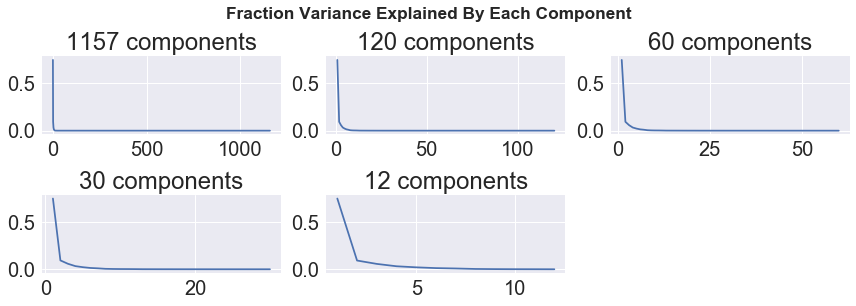

In [8]:
total_components = len(full_PCA.explained_variance_ratio_)
plt.figure(figsize=(12,4))

for idx,num_components in enumerate([total_components,120,60,30,12]):
    plt.subplot(2,3,idx+1)
    plt.plot(np.arange(1,num_components+1,1),
             full_PCA.explained_variance_ratio_[:num_components]);
    plt.title(str(num_components)+" components",
            );
    
plt.suptitle('Fraction Variance Explained By Each Component',
             fontweight='bold',
             fontsize='xx-large',
             y=1.05)
plt.tight_layout()

The cell below plots much of the same information, but now plots the variance retained when we project the data onto the number of components on the x-axis.

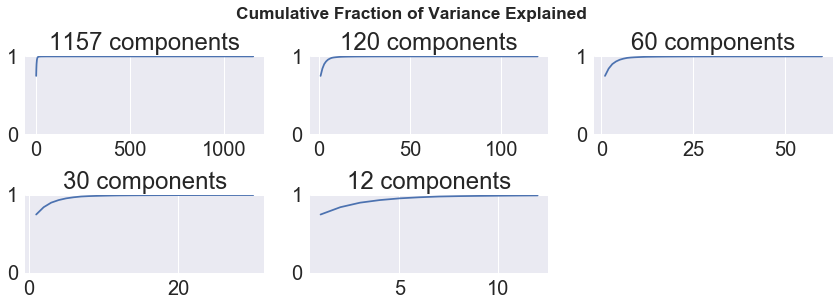

In [9]:
total_components = len(full_PCA.explained_variance_ratio_)
plt.figure(figsize=(12,4))

for idx,num_components in enumerate([total_components,120,60,30,12]):
    plt.subplot(2,3,idx+1)
    plt.plot(np.arange(1,num_components+1,1),
             np.cumsum(full_PCA.explained_variance_ratio_[:num_components])
                      );
    plt.title(str(num_components)+" components",
            #fontsize='x-large',
            );
    plt.ylim(0,1)
    
plt.suptitle('Cumulative Fraction of Variance Explained',
             fontweight='bold',fontsize='xx-large',y=1.05)
plt.tight_layout()

### Viewing the PCs

The cell below grabs the PCs selected with
`indices_to_plot` and plots them in a grid.

The "transformed" data values are just
the dot products between the data vector and each principal component.
These are called the "loadings" onto each principal component.

these components collectively explain 98.86% of the variance


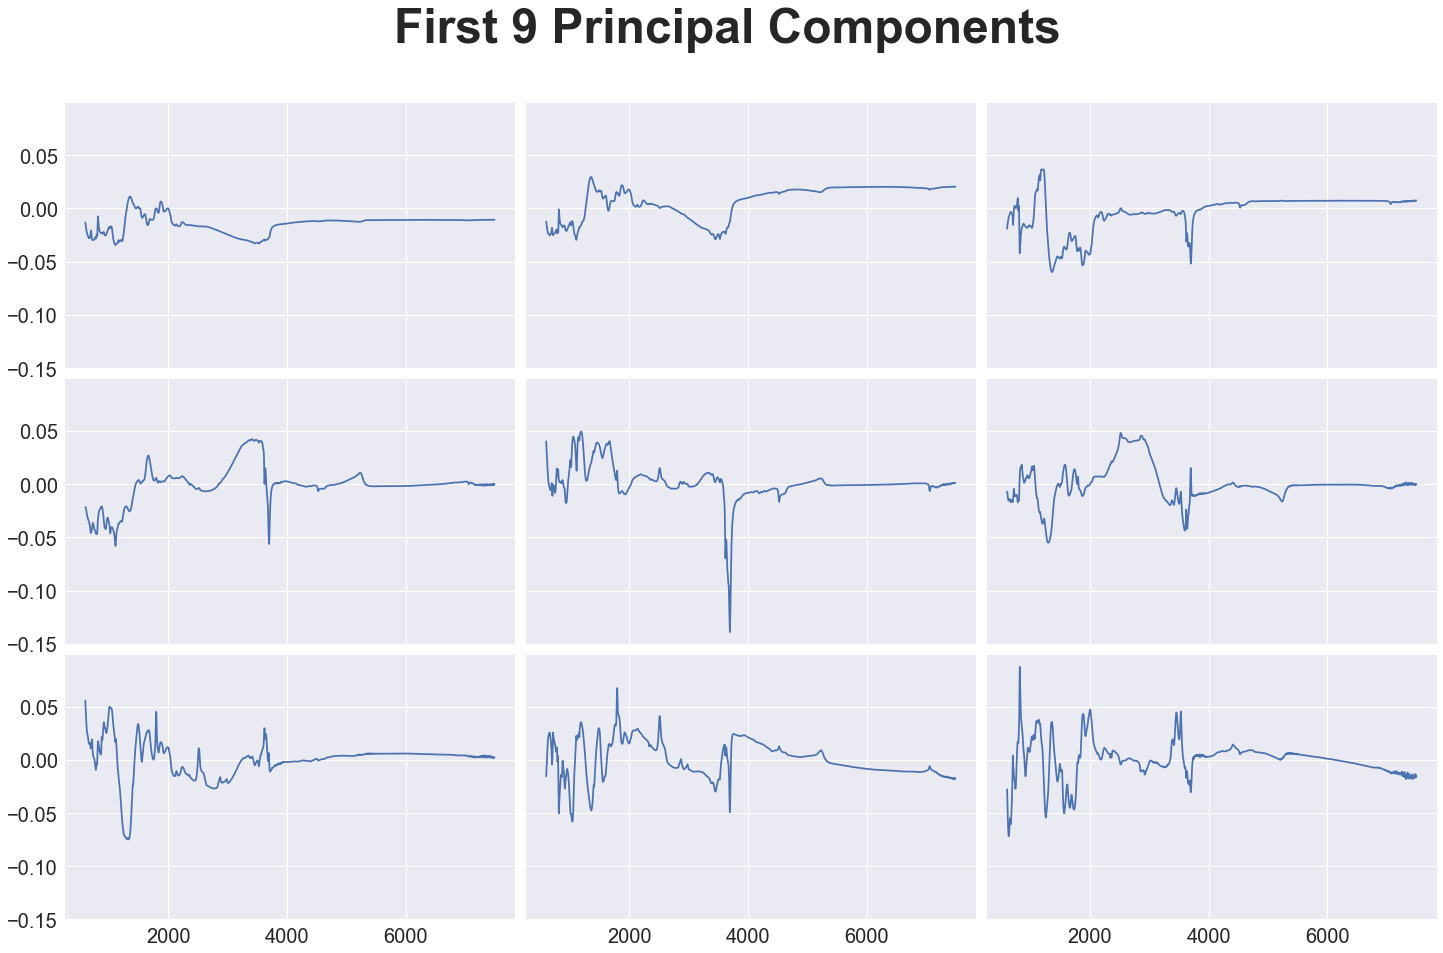

In [10]:
indices_to_plot = list(range(9))
number_to_plot = len(indices_to_plot)
components_to_plot = full_PCA.components_[indices_to_plot,:]

nrows = int(np.ceil(np.sqrt(number_to_plot)))
ncols = nrows

fig,axes = plt.subplots(nrows=nrows,ncols=ncols,
             sharex=True,sharey=True,
             figsize=(20,12),
            )
for ax,component in zip(np.ravel(axes),components_to_plot):
    ax.plot(wavenumbers,component)
    
plt.suptitle('First ' +str(number_to_plot) + ' Principal Components',
            fontweight='bold',fontsize=48,y=1.1,
            );
plt.tight_layout()

explained_variance_percent = np.sum(full_PCA.explained_variance_ratio_[indices_to_plot])*100
print("these components collectively explain {:0.2f}% of the variance".format(explained_variance_percent))

### How do our reconstructions compare to the originals?

We can "reconstruct" a spectrum
that we reduced to a lower dimension
by multiplying each of the principal components
by the loading of that datapoint onto that component.
Because of the rapid rise in the cumulative variance retained,
we can get excellent reconstructions while only keeping a small number of PCs.

In [11]:
to_keep = 3

compressive_PCA = sklearn.decomposition.PCA(n_components=to_keep).fit(X)
explained_variance_percent = np.sum(compressive_PCA.explained_variance_ratio_)*100

print("these " + str(to_keep) + " components collectively explain " + 
      "{:0.2f}% of the variance".format(explained_variance_percent))

these 3 components collectively explain 90.14% of the variance


In [12]:
transformed_data = compressive_PCA.transform(X)
reconstructions = compressive_PCA.inverse_transform(transformed_data)

Run the cell below to repeatedly compare randomly-sampled data vectors to their reconstructions.

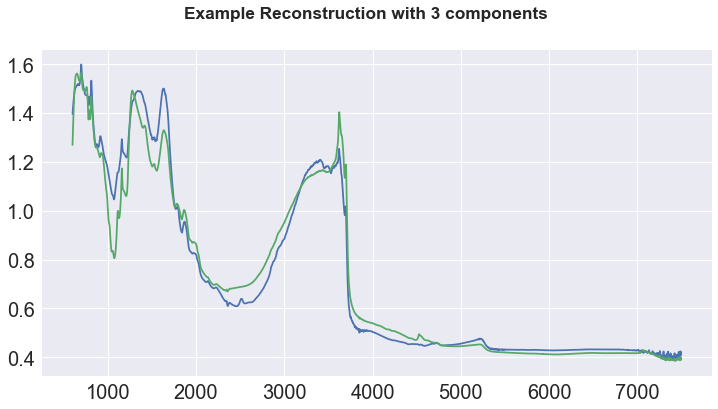

In [13]:
numDataPoints = transformed_data.shape[0]

random_idx = np.random.choice(numDataPoints)
reconstruction = reconstructions[random_idx,:]
original = X.iloc[random_idx]

plt.figure(figsize=(12,6))
plt.plot(wavenumbers,reconstruction,label='recon');
plt.plot(wavenumbers,original,label='orig');
plt.suptitle('Example Reconstruction with '+str(to_keep)+' components',
            fontweight='bold',fontsize='xx-large',
            );

### Running Linear Regression on top of PCA

The cells below perform linear regression on the PCA-transformed data values.

The results are surprisingly good for this dataset!
Despite throwing out over 99% of the data,
we still get a decent score,
because PCA helped us determine the right 1% to keep.

The notebook on
[linear models](link)
dives into linear regression with PCA more deeply.

Before we declare victory for PCA, though,
we should confirm that
the PCs are better to project onto than randomly chosen directions.
Surprisingly,
[that doesn't actually appear to be the case](./Comparing PCA to Random Projection.ipynb),
at least for linear regression.

In [14]:
to_keep = 3

compressive_PCA = sklearn.decomposition.PCA(n_components=to_keep).fit(X)
explained_variance_percent = np.sum(compressive_PCA.explained_variance_ratio_)*100

print("these " + str(to_keep) + " components collectively explain " + 
      "{:0.2f}% of the variance".format(explained_variance_percent))

these 3 components collectively explain 90.14% of the variance


In [15]:
transformed_data = compressive_PCA.transform(X)

In [16]:
LR = sklearn.linear_model.LinearRegression()

In [17]:
LR.fit(transformed_data,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [18]:
LR.score(transformed_data,y)

0.2486719490168311